# Real Estate Cluster Mapping

Note: For a version of this notebook that includes the interactive map, please use the following nbviewer [link.](https://nbviewer.org/github/sgawalsh/real-estate-data-analysis/blob/main/realEstateClusterMapping.ipynb)

In this notebook I'll be taking a kaggle dataset which provides various features of real estate data in London, and applying various data processing techniques to prepare the data to be clustered using a Kmeans clustering algorithm. I'll be investigating the effects of the number of clusters on the resulting cluster quality, then interpreting our final data to see what types of properties each cluster represents in order to better understand our original dataset and investigate any emergent trends.

In [8]:
import pandas as pd, seaborn

def toCategorical(data: pd.DataFrame, columns):
    for col in columns:
        data[col] = data[col].astype("object")

def fillMissing(data: pd.DataFrame):
    missing = data.isna().sum() > 0
    for colName in missing[missing].index:
        if data[colName].dtype == 'object':
            data[colName] = data[colName].fillna("Unknown")
        else:
            data[colName] = data[colName].fillna(data[colName].median())

def dropMissing(data: pd.DataFrame, threshold = 0.15):
    missing = data.isna().sum() / data.shape[0] > threshold
    toDrop = missing[missing].index
    print(f"Dropping {toDrop}")
    data.drop(columns=toDrop, inplace=True)

def encodeCategorical(data: pd.DataFrame) -> pd.DataFrame:
    categorical = data.dtypes == 'object'
    return pd.get_dummies(data, columns = categorical[categorical].index, drop_first=True)

def normalizeNumerical(data: pd.DataFrame, std = True):
    numericalCols = data.select_dtypes(include=['float64', 'int64']).columns
    if std: # Standard score normalization (Z-score)
        data[numericalCols] = (data[numericalCols] - data[numericalCols].mean()) / data[numericalCols].std()
    else: # Min-max normalization
        data[numericalCols] = (data[numericalCols] - data[numericalCols].min()) / (data[numericalCols].max() - data[numericalCols].min())

def visualizeCorrelations(data: pd.DataFrame):
    seaborn.heatmap(data.select_dtypes(include='float64').corr())

data = pd.read_csv("data/kaggle_london_house_price_data.csv")
print(data.info())
mapLabelData = data[['fullAddress', 'latitude', 'longitude', 'bedrooms', 'bathrooms', 'floorAreaSqM', 'saleEstimate_currentPrice']] # save labelling information
data.drop(columns=["fullAddress", "postcode", "country", "outcode", "saleEstimate_valueChange.saleDate", "history_date"], inplace=True) # drop low-info columns
toCategorical(data, ['bedrooms', 'livingRooms'])
dropMissing(data)
fillMissing(data)
normalizeNumerical(data)
data = encodeCategorical(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418201 entries, 0 to 418200
Data columns (total 28 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   fullAddress                                418201 non-null  object 
 1   postcode                                   418201 non-null  object 
 2   country                                    418201 non-null  object 
 3   outcode                                    418201 non-null  object 
 4   latitude                                   418201 non-null  float64
 5   longitude                                  418201 non-null  float64
 6   bathrooms                                  340270 non-null  float64
 7   bedrooms                                   377665 non-null  float64
 8   floorAreaSqM                               392991 non-null  float64
 9   livingRooms                                357701 non-null  float64
 10  tenure  

First we apply some basic data processing methods to prepare the data for clustering. We drop several columns which contain nominal information about the property, such as postal code and address columns. We also drop the date columns to isolate the numerical columns present in our dataset. We change the room count fields to categorical columns, so that different bedroom and living room counts are treated as different classes, rather than implying some linear relationship between different amounts of these respective rooms.

For columns where a certain threshold of data is missing, the columns are dropped, and for other columns with missing values the data is imputed. The columns are normalized so that each column is represented more evenly to the clustering agorithm then finally all categorical columns are encoded into one-hot columns to provide numerical representation for each category class.

Before the data is clustered we'll check the correlations between the float columns to see what correlations exist at this point.

(418201, 60)


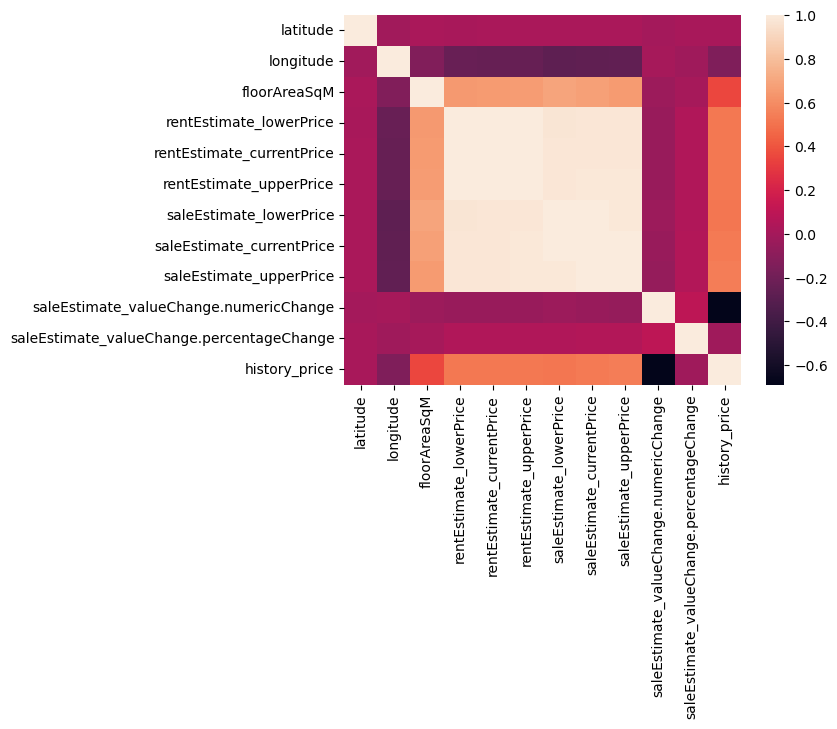

In [9]:
visualizeCorrelations(data)
print(data.shape)

In this figure, we can see that as you'd expect the price columns are all very strongly correlated with one another, and we also see a moderate positive correlation between the square footage and the price columns. Interestingly there is almost no correlation between latitude and these fields, but we do see a small negative correlation between the longitude and these price columns. Due to this observation I'll be paying special attention to how the geographic relation of each cluster relates to the price in order to investigate this observation.

In this notebook I'll be examining how both the cluster count and the PCA operations effect our final clusters, we'll get started using just our base data so we have a baseline to compare to. We can plot the inertia over a range of cluster counts in order to see how tightly our data is clustered as the number of clusters is increased, as well as print out a summary of some of the data on each cluster to get an impression of how they are being separated.

1 Clusters:
     Count    Price  Sq. Ft.  Bedrooms  Bathrooms    Lat  Long  Lat Bias  \
0  418,201  904,519       99      2.47       1.44  51.51  -0.1       0.0   

   Long Bias  Spread  
0        0.0     3.6  
4 Clusters:
     Count      Price  Sq. Ft.  Bedrooms  Bathrooms    Lat  Long  Lat Bias  \
0  111,317    766,067      114      3.08       1.42  51.51 -0.06    0.2948   
1    9,123  5,300,692      279      4.45       3.55  51.51 -0.17    0.1846   
2  240,845    549,508       68      1.80       1.20  51.51 -0.11   -0.1699   
3   56,916  1,970,481      171      3.73       2.25  51.51 -0.16    0.1127   

   Long Bias  Spread  
0     3.2032    2.92  
1    -4.4107    2.39  
2    -0.3929    3.57  
3    -3.8953    3.26  
7 Clusters:
     Count      Price  Sq. Ft.  Bedrooms  Bathrooms    Lat  Long  Lat Bias  \
0   92,154    770,018      116      3.16       1.43  51.51 -0.04    0.0242   
1      439  3,291,249      270      4.06       3.90  51.51 -0.15   -0.0107   
2  149,823    645,312    

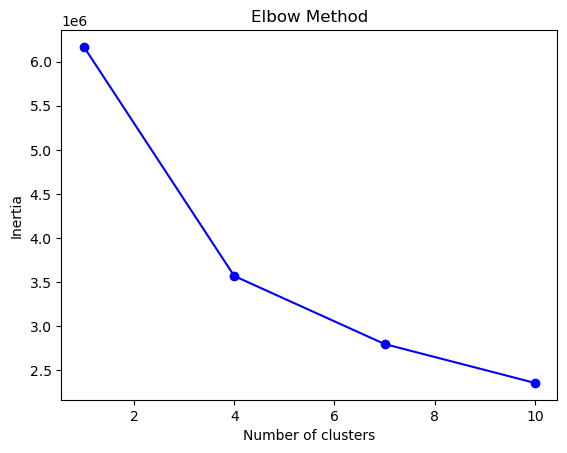

[6166502.642487213, 3570106.559596497, 2799463.2095844904, 2358621.2004077495]


In [10]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd, folium, matplotlib.pyplot as plt, math
from clustering import haversine

def graphInertias(clusterRange, inertias):
    plt.figure()
    plt.plot(clusterRange, inertias, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    plt.show()
    plt.close()

def mapCluster(labelledData: pd.DataFrame) -> pd.DataFrame:

    labels = sorted(labelledData['clusterLabels'].unique())
    print(f"{len(labels)} Clusters:")
    labelCounts = labelledData['clusterLabels'].value_counts()
    summaryDF = pd.DataFrame(columns=['Count', 'Price', 'Sq. Ft.', 'Bedrooms', 'Bathrooms', 'Lat', 'Long', 'Lat Bias', 'Long Bias', 'Spread'])

    clusterGroups = {}
    for i, label in enumerate(labels):
        clusterGroups[label] = folium.FeatureGroup(name=f"Cluster {label}")
        clusterDf = labelledData[labelledData['clusterLabels'] == label]
        clusterLatMean = clusterDf['latitude'].mean()
        clusterLonMean = clusterDf['longitude'].mean()

        clusterSpread = clusterDf.apply(
            lambda row: haversine(meanLat, meanLon, row['latitude'], row['longitude']),
            axis=1
        ).std() # std dev cluster spread in km

        summaryDF.loc[i] = [
            format(labelCounts[label], ","),
            format(round(clusterDf['saleEstimate_currentPrice'].mean()), ","),
            round(clusterDf['floorAreaSqM'].mean()),
            round(clusterDf['bedrooms'].mean(), 2),
            round(clusterDf['bathrooms'].mean(), 2),
            round(clusterLatMean, 2),
            round(clusterLonMean, 2),
            round((clusterLatMean - meanLat) * 111, 4), # latitude to km
            round((clusterLonMean - meanLon) * 111 * math.cos(math.radians((clusterLatMean + meanLat) / 2)), 4), # longitude to km
            round(clusterSpread, 2),
            ]
    print(summaryDF)
    return summaryDF

meanLat = mapLabelData['latitude'].mean()
meanLon = mapLabelData['longitude'].mean()

kRange = range(1, 13, 3)
inertias, summaryDfs = [], []
for numClusters in kRange:
    kmeans = KMeans(n_clusters=numClusters, random_state=0).fit(data)
    inertias.append(kmeans.inertia_)
    summaryDfs.append(mapCluster(pd.concat([mapLabelData, pd.Series(kmeans.labels_, name="clusterLabels")], axis=1)))

graphInertias(kRange, inertias)
print(inertias)

From our inertia graph, we can see a strong drop-off in the inertia reduction after 7 clusters, meaning that this amount is sufficient to meaningfully capture most of the categorical data available in our dataset.

Looking at our cluster output tables, we an see the our clustering algorithm has split our data into several clusters which correspond strongly to price ranges. At lower cluster counts we see a single mass-market cluster of more affordable properties, distributed over a relatively large geographical area. The rest of the clusters represent high-value and luxury property classes with much higher prices. As you'd expect, we see the positive correlation between square footage reflected in this data, as well as a positive correlation between room counts and price.

Interestingly, even after normalizing the longitudinal and latitudinal biases for each cluster, we see much greater variation in longitudinal (East/West) bias than latitudinal bias. This relationship can be visualized more clearly by creating a graph of the price vs the longitudinal position.

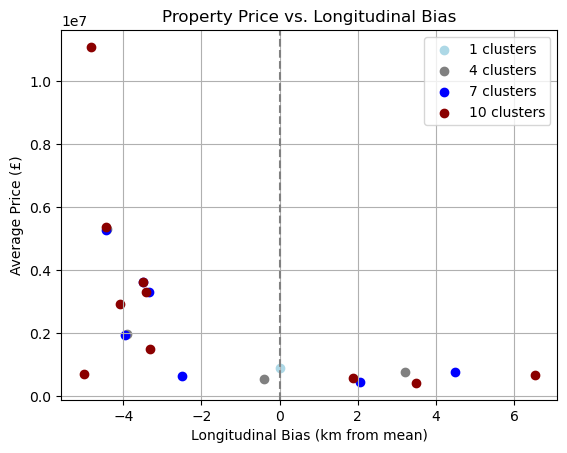

In [11]:
colours = ['lightblue', 'gray', 'blue', 'darkred', 'lightgreen', 'purple', 'red', 'green', 'lightred', 'white', 'darkblue', 'darkpurple', 'cadetblue', 'orange', 'pink']

plt.figure()
plt.xlabel("Longitudinal Bias (km from mean)")
plt.ylabel("Average Price (£)")
plt.title("Property Price vs. Longitudinal Bias")
plt.grid(True)
plt.axvline(x=0, color='gray', linestyle='--')
for i, df in enumerate(summaryDfs):
    plt.scatter(df['Long Bias'], df['Price'].str.replace(',', '').astype(float), c=colours[i], label=f"{df.shape[0]} clusters")

plt.legend()
plt.show()
plt.close()

The graph demonstrates an surprisingly strong relationship between these two values, which seems to intensify as one moves further West through London. This relationship is probably not surprising to those familiar with London, but was not expected on my part. After a little online investigation I found that this is an established market trend specifically found in London, mostly due to the Thames river, which flows Eastward through London. As neighbourhoods all tend to be situated along the river, we do not see the same large variation in latitude as we do in longitude for these clusters. As for the relationship between price and longitude, we can see that the price increases as the clusters move Westward, this is explained by historical factors which include to proximity to Buckingham palace and the associated more developed infrastructure that comes with that, as well as weather patterns in which the wind in London generally blows Eastward, so any industrial odours are experienced more strongly in neighbourhoods on the East. One can imagine how these factors might compound over time to create this trend which is still apparent today.

Obviously none of this explanatory information is available as a result of this clustering, but this process does exemplify how clustering can expose these data patterns, and can provide direction to someone seeking to unearth trends in an unknown dataset.

To wrap up, let's take a look at the cluster centers of one clustering on a scatterplot of all properties, then perform one last kmeans grouping to see how our markers are displayed on an interactive map.

     Count      Price  Sq. Ft.  Bedrooms  Bathrooms    Lat  Long  Lat Bias  \
0   92,154    770,018      116      3.16       1.43  51.51 -0.04    0.0242   
1      439  3,291,249      270      4.06       3.90  51.51 -0.15   -0.0107   
2  149,823    645,312       72      1.89       1.26  51.54 -0.14    3.8238   
3    9,249  5,282,287      274      4.42       3.49  51.51 -0.17    0.1919   
4  109,633    451,341       68      1.84       1.15  51.46 -0.07   -5.3000   
5       81  3,637,086      175      3.40       2.64  51.51 -0.15    0.3950   
6   56,822  1,943,107      172      3.75       2.24  51.51 -0.16    0.0726   

   Long Bias  Spread  
0     4.4902    2.90  
1    -3.3468    1.95  
2    -2.4904    3.97  
3    -4.4314    2.42  
4     2.0674    3.11  
5    -3.5036    2.59  
6    -3.9480    3.28  


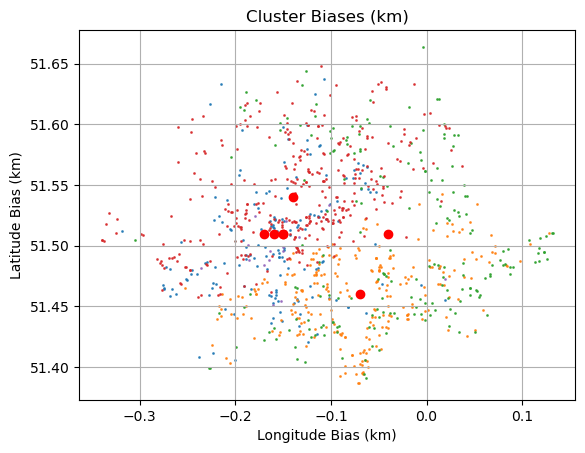

clusterLabels
2    349
4    259
0    205
6    167
3     19
1      1
Name: count, dtype: int64


In [19]:
def clusterCoordsFigure(labelledData: pd.DataFrame, clusterDF: pd.DataFrame):
    print(clusterDF)
    plt.figure()
    for label in labelledData['clusterLabels'].unique():
        toPlot = labelledData.loc[labelledData['clusterLabels'] == label]
        plt.scatter(toPlot['longitude'], toPlot['latitude'], s=1, alpha=0.8)
    plt.scatter(clusterDF['Long'], clusterDF['Lat'], color='red')
    plt.title("Cluster Biases (km)")
    plt.xlabel("Longitude Bias (km)")
    plt.ylabel("Latitude Bias (km)")
    plt.grid(True)
    plt.show()
    plt.close()

myDf = summaryDfs[2] # 7 clusters
clusterData = pd.concat([mapLabelData, pd.Series(kmeans.labels_, name="clusterLabels")], axis=1).sample(n=1000, random_state=2) # Take subset for less cluttered map, smaller clusters may be absent
clusterCoordsFigure(clusterData, myDf)

kmeans = KMeans(n_clusters=7, random_state=0).fit(data)
print(clusterData['clusterLabels'].value_counts())

clusterGroups = {}
for label in sorted(clusterData["clusterLabels"].unique()):
    clusterGroups[label] = folium.FeatureGroup(name=f"Cluster {label}")

for _, row in clusterData.iterrows():
    popupInfo = f"""
        <b>{row['fullAddress']}</b><br>
        Cluster: {row['clusterLabels']}<br>
        Bedrooms: {row['bedrooms']}<br>
        Bathrooms: {row['bathrooms']}<br>
        Square Footage: {row['floorAreaSqM']}<br>
        Sales Price Estimate: {row['saleEstimate_currentPrice']}<br>
    """
    marker = folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=popupInfo,
        icon=folium.Icon(color=colours[row['clusterLabels'] % len(colours)])
        )
    clusterGroups[row['clusterLabels']].add_child(marker)

foliumMap = folium.Map(location=[meanLat, meanLon], zoom_start=12)
# # Add all FeatureGroups to the map
for group in clusterGroups.values():
    group.add_to(foliumMap)

# # Add layer control to toggle visibility
folium.LayerControl(collapsed=False).add_to(foliumMap)

foliumMap